In [1]:
# import modules
import numpy as np
from sklearn.svm import SVC
from joblib import dump, load # to load trained classifier
import matplotlib.pyplot as plt
from scipy.stats import skew

In [2]:
A_hat = np.load('A_hat_250.npy')
S_hat_T = np.load('S_hat_T_250.npy')

In [3]:
# load trained classifier
svc = load('svc_r1_250.joblib')

In [4]:
# load ICA embeddings
embedded_tweets = np.load('tweet_embed_250.npy')

# Define explainability function

In [5]:
def expl_word(A = None, S_T = None, n_comp = None, word_index = 0):
    # A: matrix of target words by source components
    # S^T: matrix of context words by source components
    # n_comp: number of components to use when calculating explainability value for word
    # word_index: index of word in rows of A & S^T (same index)
    
    # if n_comp not specified, set to number of components
    if not n_comp:
        n_comp = A.shape[1]
        
    # if n_comp too large, reset
    if n_comp > A.shape[1]:
        n_comp = A.shape[1]
    
    # check skewness
    ST_skewness = skew(S_T)
    ST_negSkew = np.argwhere(ST_skewness < 0)[:,0]
    # adjust accordingly
    S_T[:,ST_negSkew] *= -1
    A[:,ST_negSkew] *= -1
    
    S = S_T.T # S is source components by context words
    
    a_i = A[word_index,:] # shape: 1 x source components
    s_i = S[:,word_index] # shape: source components x 1
    
    largest_a = a_i.argsort()[-n_comp:] #reorder & get indices of n_comp largest values
    a_subset = a_i[largest_a] # extract first n_comp largest components
    
    s_subset = s_i[largest_a] # extract components matching a's n_comp largest components
    
    word_val = np.dot(a_subset, s_subset) # shape: 1 x 1
    
    return word_val

In [6]:
# test
expl_word(A_hat, S_hat_T)

20.430761697367466

In [7]:
expl_word(A_hat, S_hat_T, word_index = 3, n_comp = 2)

2.520112593929456

In [8]:
expl_word(A_hat, S_hat_T, word_index = 200)

7.83449074851026

# Get predictions

In [9]:
# get train set
class1_train_indices = list(range(100))
class0_train_indices = list(range(280,380))
hundred_ones = [1]*100
hundred_zeros = [0]*100
train_Y = hundred_ones + hundred_zeros

# get test set
class1_test_indices = list(range(100,280)) 
class0_test_indices = list(range(380,560))
test_indices = class1_test_indices + class0_test_indices

test_X = embedded_tweets[[test_indices],:][0]

# model predictions for test set
y_hat_test = svc.predict(test_X)

# model predictions for all tweets
y_hat_all = svc.predict(embedded_tweets)

## Test set tweets

In [10]:
# sort reliable & unreliable tweets
unreliable_test_ids = []
reliable_test_ids = []

for ind, yhat in zip(test_indices, y_hat_test):
    if yhat == 1:
        unreliable_test_ids.append(ind)
    else:
        reliable_test_ids.append(ind)

## All tweets

In [11]:
all_ids = list(range(560))

# sort reliable & unreliable tweets
unreliable_all_ids = []
reliable_all_ids = []

for ind, yhat in zip(all_ids, y_hat_all):
    if yhat == 1:
        unreliable_all_ids.append(ind)
    else:
        reliable_all_ids.append(ind)

# Word embeddings: unreliable vs reliable (classified)

In [12]:
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.base import TransformerMixin
from sklearn.decomposition import FastICA
from sklearn.preprocessing import StandardScaler
import re
from nltk.stem import WordNetLemmatizer
import pandas as pd

In [13]:
# to convert contractions picked up by word_tokenize() into full words
contractions = {
    "n't": 'not',
    "'ve": 'have',
    "'s": 'is', # note that this will include possessive nouns
    'gonna': 'going to',
    'gotta': 'got to',
    "'d": 'would',
    "'ll": 'will',
    "'re": 'are',
    "'m": 'am',
    'wanna': 'want to'
}

# to convert nltk_pos tags to wordnet-compatible PoS tags
def convert_pos_wordnet(tag):
    tag_abbr = tag[0].upper()
    tag_dict = {
        'J': wordnet.ADJ,
        'N': wordnet.NOUN,
        'V': wordnet.VERB,
        'R': wordnet.ADV
    }
                
    if tag_abbr in tag_dict:
        return tag_dict[tag_abbr]

In [14]:
class ContextMatrix(TransformerMixin):
    
    # initialize class & private variables
    def __init__(self,
                 window_size = 4,
                 remove_stopwords = True,
                 add_start_end_tokens = True,
                 lowercase = False,
                 lemmatize = False,
                 pmi = False,
                 spmi_k = 1,
                 laplace_smoothing = 0,
                 pmi_positive = False,
                 sppmi_k = 1):
        
        """ Params:
                window_size: size of +/- context window (default = 4)
                remove_stopwords: boolean, whether or not to remove NLTK English stopwords
                add_start_end_tokens: boolean, whether or not to append <START> and <END> to the
                beginning/end of each document in the corpus (default = True)
                lowercase: boolean, whether or not to convert words to all lowercase
                lemmatize: boolean, whether or not to lemmatize input text
                pmi: boolean, whether or not to compute pointwise mutual information
                pmi_positive: boolean, whether or not to compute positive PMI
        """
        self.window_size = window_size
        self.remove_stopwords = remove_stopwords
        self.add_start_end_tokens = add_start_end_tokens
        self.lowercase = lowercase
        self.lemmatize = lemmatize
        self.pmi = pmi
        self.spmi_k = spmi_k
        self.laplace_smoothing = laplace_smoothing
        self.pmi_positive = pmi_positive
        self.sppmi_k = sppmi_k
        self.corpus = None
        self.clean_corpus = None
        self.vocabulary = None
        self.X = None
        self.doc_terms_lists = None
    
    def fit(self, corpus, y = None):
        
        """ Learn the dictionary of all unique tokens for given corpus.
        
            Params:
                corpus: list of strings
            
            Returns: self
        """
        self.corpus = corpus
        
        term_dict = dict()
        k = 0
        corpus_words = []
        clean_corpus = []
        doc_terms_lists = []
        detokenizer = TreebankWordDetokenizer()
        lemmatizer = WordNetLemmatizer()
        
        for text in corpus:
            text = re.sub(r'[_~`@$%^&*[\]+=\|}{\"\'<>/]+', '', text)
            
            words = word_tokenize(text)
            
            if self.remove_stopwords:
                clean_words = []
                for word in words:
                    if word.lower() not in set(stopwords.words('english')):
                        clean_words.append(word)
                words = clean_words
                
            if self.lowercase:
                clean_words = []
                for word in words:
                    clean_words.append(word.lower())
                
                words = clean_words
                
            if self.lemmatize:
                clean_words = []
                for word in words:
                    PoS_tag = pos_tag([word])[0][1]
                    
                    # to change contractions to full word form
                    if word in contractions:
                        word = contractions[word]

                    if PoS_tag[0].upper() in 'JNVR':
                        word = lemmatizer.lemmatize(word, convert_pos_wordnet(PoS_tag))
                    else:
                        word = lemmatizer.lemmatize(word)

                    clean_words.append(word)
                    
                words = clean_words
            
            # detokenize trick taken from this StackOverflow post:
            # https://stackoverflow.com/questions/21948019/python-untokenize-a-sentence
            # and NLTK treebank documentation:
            # https://www.nltk.org/_modules/nltk/tokenize/treebank.html
            text = detokenizer.detokenize(words)
            clean_corpus.append(text)
            
            [corpus_words.append(word) for word in words]
            
            if self.add_start_end_tokens:
                words = ['<START>'] + words + ['<END>']
            
            doc_terms_lists.append(words)
            
        self.clean_corpus = clean_corpus
        
        self.doc_terms_lists = doc_terms_lists
        
        corpus_words = list(set(corpus_words))
        
        if self.add_start_end_tokens:
            corpus_words = ['<START>'] + corpus_words + ['<END>']
        
        corpus_words = sorted(corpus_words)
        
        for el in corpus_words:
            term_dict[el] = k
            k += 1
            
        self.vocabulary = term_dict
        
        return self
        
    def transform(self, new_corpus = None, y = None):
        
        """ Compute the co-occurrence matrix for given corpus and window_size, using term dictionary
            obtained with fit method.
        
            Returns: term-context co-occurrence matrix (shape: target terms by context terms) with
            raw counts
        """
        num_terms = len(self.vocabulary)
        window = self.window_size
        X = np.full((num_terms, num_terms), self.laplace_smoothing)
        
        lemmatizer = WordNetLemmatizer()
        if type(new_corpus) != list:
            new_corpus = self.corpus
        
        for text in new_corpus:
            text = re.sub(r'[_~`@$%^&*[\]+=\|}{\"\'<>/]+', '', text)
            
            words = word_tokenize(text)
            
            if self.remove_stopwords:
                clean_words = []
                for word in words:
                    if word.lower() not in set(stopwords.words('english')):
                        clean_words.append(word)
                words = clean_words
                
            if self.lowercase:
                clean_words = []
                for word in words:
                    clean_words.append(word.lower())
                
                words = clean_words
                
            if self.lemmatize:
                clean_words = []
                for word in words:
                    PoS_tag = pos_tag([word])[0][1]
                    
                    # to change contractions to full word form
                    if word in contractions:
                        word = contractions[word]

                    if PoS_tag[0].upper() in 'JNVR':
                        word = lemmatizer.lemmatize(word, convert_pos_wordnet(PoS_tag))
                    else:
                        word = lemmatizer.lemmatize(word)

                    clean_words.append(word)
                    
                words = clean_words
                
            if self.add_start_end_tokens:
                words = ['<START>'] + words + ['<END>']
            
            for i in range(len(words)):
                target = words[i]
                
                # check to see if target word is in the dictionary; if not, skip
                if target in self.vocabulary:
                    
                    # grab index from dictionary
                    target_dict_index = self.vocabulary[target]
                    
                    # find left-most and right-most window indices for each target word
                    left_end_index = max(i - window, 0)
                    right_end_index = min(i + window, len(words) - 1)
                    
                    # loop over all words within window
                    # NOTE: this will include the target word; make sure to skip over it
                    for j in range(left_end_index, right_end_index + 1):
                        
                        # skip "context word" where the "context word" index is equal to the
                        # target word index
                        if j != i:
                            context_word = words[j]
                            
                            # check to see if context word is in the fitted dictionary; if
                            # not, skip
                            if context_word in self.vocabulary:
                                X[target_dict_index, self.vocabulary[context_word]] += 1
        
        # if pmi = True, compute pmi matrix from word-context raw frequencies
        # more concise code taken from this StackOverflow post:
        # https://stackoverflow.com/questions/58701337/how-to-construct-ppmi-matrix-from-a-text-corpus
        if self.pmi:
            denom = X.sum()
            col_sums = X.sum(axis = 0)
            row_sums = X.sum(axis = 1)
            
            expected = np.outer(row_sums, col_sums)/denom
            
            X = X/expected
            
            for i in range(X.shape[0]):
                for j in range(X.shape[1]):
                
                    if X[i,j] > 0:
                        X[i,j] = np.log(X[i,j]) - np.log(self.spmi_k)
                        
                        if self.pmi_positive:
                            X[i,j] = max(X[i,j] - np.log(self.sppmi_k), 0)
        
        # note that X is a dense matrix
        self.X = X

        return X

In [15]:
tweets = pd.read_csv('COVID19_Dataset-text_labels_only.csv')

## Unreliable embeddings

In [16]:
unrel_tweets = tweets.iloc[unreliable_all_ids]

In [17]:
cmu = ContextMatrix(window_size = 15, lowercase = True, lemmatize = True, pmi = True)

In [18]:
word_context_matrix = cmu.fit_transform(unrel_tweets['Tweet'])

In [19]:
ica = FastICA(n_components = 250, random_state = 3)
std_scaler = StandardScaler()
X_std = std_scaler.fit_transform(word_context_matrix)
    
st_unrel = ica.fit_transform(X_std)
a_unrel = ica.mixing_

In [20]:
# check skewness
unrel_skewness = skew(st_unrel)
unrel_negSkew = np.argwhere(unrel_skewness < 0)[:,0]

In [21]:
# because this is S_hat transpose...
st_unrel_corrected = st_unrel.copy()
st_unrel_corrected[:,unrel_negSkew] *= -1

In [22]:
a_unrel_corrected = a_unrel.copy()
a_unrel_corrected[:,unrel_negSkew] *= -1

In [23]:
# test for word 857
a_word857 = a_unrel_corrected[856,:]
a_word857.sort()
np.ediff1d(a_word857)

array([8.88659275e-02, 8.41378374e-02, 2.09840602e-01, 5.19882756e-02,
       5.71699945e-02, 3.20166478e-02, 3.37791999e-03, 3.31586278e-02,
       1.92712287e-02, 1.66960298e-02, 2.85170409e-02, 2.40030707e-03,
       2.28615708e-02, 5.40447105e-03, 1.05420763e-02, 9.42706910e-03,
       6.70476404e-03, 6.84609836e-04, 2.98904453e-02, 1.30761574e-03,
       9.30516024e-03, 2.16535154e-02, 9.27397249e-04, 8.07968829e-04,
       5.21204189e-03, 7.97102018e-03, 4.75825629e-03, 7.20830405e-03,
       7.04544788e-04, 2.53302915e-03, 5.58450248e-03, 4.19963735e-03,
       1.60512324e-02, 5.10066747e-03, 8.45792941e-03, 1.67036885e-03,
       1.21052757e-03, 7.38441709e-03, 1.18016498e-03, 1.45052552e-03,
       4.85292350e-03, 3.47380712e-03, 5.91098039e-03, 1.26799023e-03,
       2.25564840e-03, 3.07729093e-03, 9.80668628e-03, 1.61443644e-02,
       5.42382016e-03, 1.28752187e-02, 2.84185105e-03, 4.06396922e-03,
       1.03485227e-03, 1.38874425e-02, 5.14117487e-03, 3.72644673e-03,
      

In [24]:
a_word857

array([-1.33363545e+00, -1.24476953e+00, -1.16063169e+00, -9.50791087e-01,
       -8.98802811e-01, -8.41632817e-01, -8.09616169e-01, -8.06238249e-01,
       -7.73079621e-01, -7.53808392e-01, -7.37112363e-01, -7.08595322e-01,
       -7.06195015e-01, -6.83333444e-01, -6.77928973e-01, -6.67386897e-01,
       -6.57959827e-01, -6.51255063e-01, -6.50570454e-01, -6.20680008e-01,
       -6.19372393e-01, -6.10067232e-01, -5.88413717e-01, -5.87486320e-01,
       -5.86678351e-01, -5.81466309e-01, -5.73495289e-01, -5.68737032e-01,
       -5.61528728e-01, -5.60824184e-01, -5.58291154e-01, -5.52706652e-01,
       -5.48507015e-01, -5.32455782e-01, -5.27355115e-01, -5.18897185e-01,
       -5.17226816e-01, -5.16016289e-01, -5.08631872e-01, -5.07451707e-01,
       -5.06001181e-01, -5.01148258e-01, -4.97674451e-01, -4.91763470e-01,
       -4.90495480e-01, -4.88239832e-01, -4.85162541e-01, -4.75355854e-01,
       -4.59211490e-01, -4.53787670e-01, -4.40912451e-01, -4.38070600e-01,
       -4.34006631e-01, -

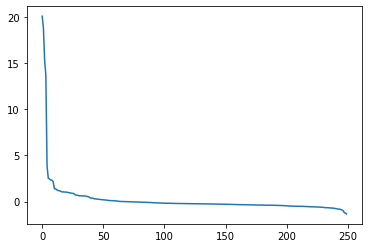

In [25]:
plt.plot(a_word857[::-1])

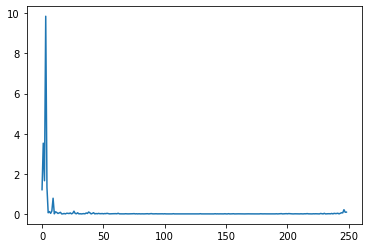

In [26]:
plt.plot(np.ediff1d(a_word857)[::-1])

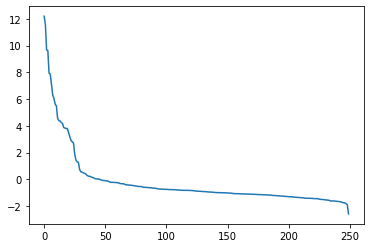

In [27]:
a_word1 = a_unrel_corrected[0,:]
a_word1.sort()
plt.plot(a_word1[::-1])

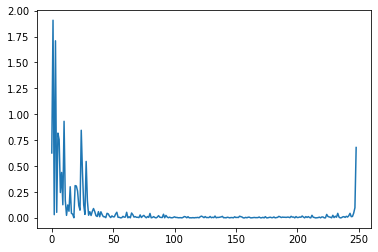

In [28]:
plt.plot(np.ediff1d(a_word1)[::-1])

In [29]:
a_word1[::-1]

array([12.20103756, 11.57426187,  9.66693544,  9.63569647,  7.92669928,
        7.87298218,  7.05452624,  6.29993262,  6.05486118,  5.61622095,
        5.48918609,  4.55685555,  4.38881957,  4.36426479,  4.23928357,
        4.17477665,  3.87386845,  3.82972779,  3.79335629,  3.7917703 ,
        3.47991144,  3.1718809 ,  2.91243571,  2.7937928 ,  2.71911224,
        1.87351188,  1.43468371,  1.30758971,  1.27354778,  0.72848793,
        0.56193098,  0.53606971,  0.47595065,  0.45278079,  0.38949323,
        0.29891395,  0.23783987,  0.21603265,  0.20240498,  0.14196413,
        0.13058436,  0.07140507,  0.0389323 ,  0.02677608,  0.0153212 ,
        0.01293465, -0.03149676, -0.07033616, -0.08716128, -0.09077881,
       -0.11021851, -0.12050025, -0.13126603, -0.16878858, -0.22348685,
       -0.22946294, -0.23541072, -0.23621458, -0.23851506, -0.25360718,
       -0.26063465, -0.26932982, -0.32373993, -0.3249787 , -0.33649917,
       -0.33743437, -0.38472663, -0.41646994, -0.42447269, -0.43

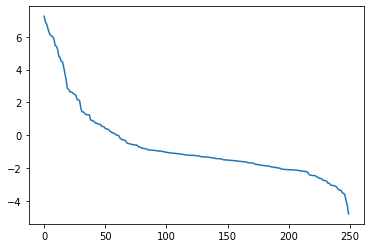

In [30]:
a_word2 = a_unrel_corrected[1,:]
a_word2.sort()
plt.plot(a_word2[::-1])

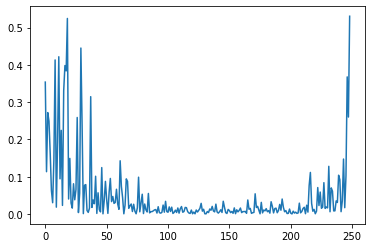

In [31]:
plt.plot(np.ediff1d(a_word2)[::-1])

## Reliable embeddings

In [32]:
rel_tweets = tweets.iloc[reliable_all_ids]

In [33]:
cmr = ContextMatrix(window_size = 15, lowercase = True, lemmatize = True, pmi = True)

In [34]:
word_context_matrix = cmr.fit_transform(rel_tweets['Tweet'])

In [35]:
ica = FastICA(n_components = 250, random_state = 3)
std_scaler = StandardScaler()
X_std = std_scaler.fit_transform(word_context_matrix)
    
st_rel = ica.fit_transform(X_std)
a_rel = ica.mixing_

# Word values

In [36]:
# get list of unique words over all tweets
unique_words = list(cmu.vocabulary.keys()) + list(cmr.vocabulary.keys())
unique_words = list(set(unique_words))
unique_words.sort()

word_vals = []
for i in range(len(unique_words)):
    word = unique_words[i]
    
    unrel = 0
    rel = 0
    
    if word in cmu.vocabulary:
        unrel_idx = cmu.vocabulary[word]
        unrel = expl_word(a_unrel, st_unrel, word_index = unrel_idx, n_comp = 3) # pos A, S
    
    if word in cmr.vocabulary:
        rel_idx = cmr.vocabulary[word]
        rel = expl_word(a_rel, st_unrel, word_index = rel_idx, n_comp = 3) # neg A, S
    
    tup = (word, unrel, rel)
    word_vals.append(tup)

In [37]:
word_vals

[('!', 5.371123366424654, -0.5540118736640837),
 ('#', 2.1235835141442525, 0.7826824631470677),
 ('(', 4.386693226550708, 0.0708619800237955),
 (')', 4.1953959889014065, 0.07024927154407345),
 (',', 1.6998600124219372, 0.32235350033163546),
 ('-', 5.214574121134725, 0.12465145271360273),
 ('--', 17.285997870525314, -0.03980446784414668),
 ('.', 1.5407616321804645, 0.6959812522205187),
 ('..', 12.242904970859236, 0),
 ('...', 9.868931317378829, 0),
 ('....', 12.594089241248179, 0),
 ('1', 15.080043187170222, -0.12826410043963238),
 ('1,600', 13.192694896154025, 0),
 ('1,975', 0, -0.029820096074484104),
 ('1-', 9.10029497865445, 0),
 ('10', 12.877166829302194, 0),
 ('10,000', 14.231474832770243, 0.019855232503049314),
 ('100', 13.378262147207312, 0),
 ('1000', 13.905177421522046, 0),
 ('10:30', 0, 0.5125979040912051),
 ('10:30am', 13.80057155322814, 0),
 ('10th', 0, -0.40640744675522306),
 ('11', 0, -0.04898676661851406),
 ('115', 0, -0.0682800851022257),
 ('118,000', 0, -0.1610934070871

In [48]:
cmr.vocabulary['fight']

356

In [51]:
a_fight = a_rel[356,:]
a_fight.sort()
a_fight[::-1]

array([ 2.18595949e+01,  1.39538927e+01,  8.75598338e+00,  1.87200386e+00,
        1.14971608e+00,  9.65916687e-01,  7.41478140e-01,  7.26067220e-01,
        5.86001441e-01,  5.40827546e-01,  5.21841230e-01,  5.17069610e-01,
        5.09347749e-01,  5.02092176e-01,  4.97347838e-01,  4.66115318e-01,
        4.50147182e-01,  4.40130273e-01,  4.31598129e-01,  4.24838511e-01,
        4.23336065e-01,  4.13977151e-01,  4.08158438e-01,  4.05842566e-01,
        4.05770073e-01,  3.91292491e-01,  3.89483428e-01,  3.81177840e-01,
        3.78665419e-01,  3.77286216e-01,  3.77180849e-01,  3.76693397e-01,
        3.73074725e-01,  3.55700224e-01,  3.36894188e-01,  3.33681240e-01,
        3.30202380e-01,  3.22300395e-01,  3.17581399e-01,  3.10496911e-01,
        3.08183653e-01,  3.07581060e-01,  3.05185902e-01,  3.03085233e-01,
        3.02031729e-01,  3.00366355e-01,  2.92314323e-01,  2.90018380e-01,
        2.88735828e-01,  2.85078251e-01,  2.81718186e-01,  2.80819117e-01,
        2.74748041e-01,  

In [52]:
fight_ind = cmu.vocabulary['fight']

a_fight_u = a_unrel[fight_ind,:]
a_fight_u.sort()
a_fight_u[::-1]

array([ 2.22593757e+01,  1.95459345e+01,  1.84852017e+01,  4.11809582e+00,
        2.96496413e+00,  2.73077726e+00,  2.41174423e+00,  2.16455349e+00,
        1.89094445e+00,  1.88208232e+00,  1.77158853e+00,  1.68017524e+00,
        1.65089601e+00,  1.53648330e+00,  1.47854631e+00,  1.36448762e+00,
        1.31100144e+00,  1.30598222e+00,  1.26416301e+00,  1.17527740e+00,
        1.07216674e+00,  1.02609031e+00,  1.01597923e+00,  9.93022369e-01,
        9.10169238e-01,  7.67596259e-01,  7.17829799e-01,  6.99746655e-01,
        6.79948814e-01,  6.78265487e-01,  6.77862860e-01,  6.55720351e-01,
        6.53344505e-01,  6.45372506e-01,  5.78053081e-01,  5.64333675e-01,
        5.63496144e-01,  5.56327652e-01,  5.18998030e-01,  5.17092873e-01,
        5.08874237e-01,  4.87213132e-01,  4.86624602e-01,  4.85128155e-01,
        4.81941482e-01,  4.58364232e-01,  4.24064451e-01,  4.11159705e-01,
        3.67333892e-01,  3.66107220e-01,  3.52423454e-01,  3.50261109e-01,
        3.43617771e-01,  

# Plot results

In [38]:
# define function to get words from string

def get_tweet_words(text, # string to extract list of words from
                    remove_stopwords = True,
                    lowercase = True,
                    lemmatize = True,
                    add_start_end_tokens = True): # array of avg. word magnitudes where index matches term dict. val
    
    lemmatizer = WordNetLemmatizer()
    
    text = re.sub(r'[_~`@$%^&*[\]+=\|}{\"\'<>/]+', '', text)
    words = word_tokenize(text)
    
    if remove_stopwords:
        clean_words = []
        for word in words:
            if word.lower() not in set(stopwords.words('english')):
                clean_words.append(word)
        words = clean_words

    if lowercase:
        clean_words = []
        for word in words:
            clean_words.append(word.lower())

        words = clean_words

    if lemmatize:
        clean_words = []
        for word in words:
            PoS_tag = pos_tag([word])[0][1]

            # to change contractions to full word form
            if word in contractions:
                word = contractions[word]

            if PoS_tag[0].upper() in 'JNVR':
                word = lemmatizer.lemmatize(word, convert_pos_wordnet(PoS_tag))
            else:
                word = lemmatizer.lemmatize(word)

            clean_words.append(word)

        words = clean_words

    if add_start_end_tokens:
        words = ['<START>'] + words + ['<END>']
            
    return words

In [39]:
# set up embedder for LIME pipeline
class Text2Embed(TransformerMixin):
    """ Description:
        Transformer that takes in a list of strings, calculates the word-context matrix
        (with any specified transformations), reduces the dimensionality of these word
        embeddings, and then provides the text embeddings of a (new) list of texts
        depending on which words in the "vocab" occur in the (new) strings.
    """

    # initialize class & private variables
    def __init__(self,
                 window_size=4,
                 remove_stopwords=True,
                 add_start_end_tokens=True,
                 lowercase=False,
                 lemmatize=False,
                 pmi=False,
                 spmi_k=1,
                 laplace_smoothing=0,
                 pmi_positive=False,
                 sppmi_k=1,
                 n_components=250,
                 random_state=4):

        """ Params:
                window_size: size of +/- context window (default = 4)
                remove_stopwords: boolean, whether or not to remove NLTK English stopwords
                add_start_end_tokens: boolean, whether or not to append <START> and <END> to the
                beginning/end of each document in the corpus (default = True)
                lowercase: boolean, whether or not to convert words to all lowercase
                lemmatize: boolean, whether or not to lemmatize input text
                pmi: boolean, whether or not to compute pointwise mutual information
                spmi_k: numeric, shifted pmi value
                pmi_positive: boolean, whether or not to compute positive PMI
                sppmi_k: numeric, shifted ppmi value
                n_components: number of components for PCA/FastICA
                random_state: set seed for FastICA
        """
        self.window_size = window_size
        self.remove_stopwords = remove_stopwords
        self.add_start_end_tokens = add_start_end_tokens
        self.lowercase = lowercase
        self.lemmatize = lemmatize
        self.pmi = pmi
        self.spmi_k = spmi_k
        self.laplace_smoothing = laplace_smoothing
        self.pmi_positive = pmi_positive
        self.sppmi_k = sppmi_k
        self.corpus = None
        self.clean_corpus = None
        self.vocabulary = None
        self.X = None
        self.doc_terms_lists = None
        self.ica = FastICA(n_components=n_components, random_state=random_state)
        self.scaler = StandardScaler()
        self.word_embeddings = None
        self.text_embeddings = None

    def fit(self, corpus, y=None):

        """ Learn the dictionary of all unique tokens for given corpus. Compute the co-occurrence matrix
            for input corpus and window_size, using term dictionary. Reduce dimensionality of embeddings.

            Params:
                corpus: list of strings

            Returns: self
        """
        self.corpus = corpus

        term_dict = dict()
        k = 0
        corpus_words = []
        clean_corpus = []
        doc_terms_lists = []
        detokenizer = TreebankWordDetokenizer()
        lemmatizer = WordNetLemmatizer()

        for text in corpus:
            text = re.sub(r'[_~`@$%^&*[\]+=\|}{\"\'<>/]+', '', text)

            words = word_tokenize(text)

            if self.remove_stopwords:
                clean_words = []
                for word in words:
                    if word.lower() not in set(stopwords.words('english')):
                        clean_words.append(word)
                words = clean_words

            if self.lowercase:
                clean_words = []
                for word in words:
                    clean_words.append(word.lower())

                words = clean_words

            if self.lemmatize:
                clean_words = []
                for word in words:
                    PoS_tag = pos_tag([word])[0][1]

                    # to change contractions to full word form
                    if word in contractions:
                        word = contractions[word]

                    if PoS_tag[0].upper() in 'JNVR':
                        word = lemmatizer.lemmatize(word, convert_pos_wordnet(PoS_tag))
                    else:
                        word = lemmatizer.lemmatize(word)

                    clean_words.append(word)

                words = clean_words

            # detokenize trick taken from this StackOverflow post:
            # https://stackoverflow.com/questions/21948019/python-untokenize-a-sentence
            # and NLTK treebank documentation:
            # https://www.nltk.org/_modules/nltk/tokenize/treebank.html
            text = detokenizer.detokenize(words)
            clean_corpus.append(text)

            [corpus_words.append(word) for word in words]

            if self.add_start_end_tokens:
                words = ['<START>'] + words + ['<END>']

            doc_terms_lists.append(words)

        self.clean_corpus = clean_corpus

        self.doc_terms_lists = doc_terms_lists

        corpus_words = list(set(corpus_words))

        if self.add_start_end_tokens:
            corpus_words = ['<START>'] + corpus_words + ['<END>']

        corpus_words = sorted(corpus_words)

        for el in corpus_words:
            term_dict[el] = k
            k += 1

        self.vocabulary = term_dict

        num_terms = len(self.vocabulary)
        window = self.window_size
        X = np.full((num_terms, num_terms), self.laplace_smoothing)

        for el in range(len(clean_corpus)):
            words = doc_terms_lists[el]

            # Construct word-context matrix
            for i in range(len(words)):
                target = words[i]

                # grab index from dictionary
                target_dict_index = self.vocabulary[target]

                # find left-most and right-most window indices for each target word
                left_end_index = max(i - window, 0)
                right_end_index = min(i + window, len(words) - 1)

                # loop over all words within window
                # NOTE: this will include the target word; make sure to skip over it
                for j in range(left_end_index, right_end_index + 1):

                    # skip "context word" where the "context word" index is equal to the
                    # target word index
                    if j != i:
                        context_word = words[j]

                        # count co-occurrence of target and context words
                        X[target_dict_index, self.vocabulary[context_word]] += 1

        # if pmi = True, compute pmi matrix from word-context raw frequencies
        # more concise code taken from this StackOverflow post:
        # https://stackoverflow.com/questions/58701337/how-to-construct-ppmi-matrix-from-a-text-corpus
        if self.pmi:
            denom = X.sum()
            col_sums = X.sum(axis=0)
            row_sums = X.sum(axis=1)

            expected = np.outer(row_sums, col_sums) / denom

            X = X / expected

            for i in range(X.shape[0]):
                for j in range(X.shape[1]):

                    if X[i, j] > 0:
                        X[i, j] = np.log(X[i, j]) - np.log(self.spmi_k)

                        if self.pmi_positive:
                            X[i, j] = max(X[i, j] - np.log(self.sppmi_k), 0)

        # note that X is a dense matrix
        self.X = X

        word_embeddings = self.scaler.fit_transform(self.X)
        word_embeddings = self.ica.fit_transform(word_embeddings)

        # transformed WordICA embeddings
        self.word_embeddings = word_embeddings

        return self

    def transform(self, new_corpus=None, y=None):

        """ Get text embeddings for given corpus, using term dictionary and word embeddings obtained
            with fit method.

            Returns: text embeddings (shape: num texts by embedding dimensions)
        """
        lemmatizer = WordNetLemmatizer()
        #if type(new_corpus) != list:
            #exit()

        for k in range(len(new_corpus)):
            text = new_corpus[k]
            text = re.sub(r'[_~`@$%^&*[\]+=\|}{\"\'<>/]+', '', text)
            text_vec = np.zeros(self.word_embeddings.shape[1])
            words = word_tokenize(text)
            tracker = 0  # to track whether we've encountered a word for which we have an embedding (in each tweet)

            if self.remove_stopwords:
                clean_words = []
                for word in words:
                    if word.lower() not in set(stopwords.words('english')):
                        clean_words.append(word)
                words = clean_words

            if self.lowercase:
                clean_words = []
                for word in words:
                    clean_words.append(word.lower())

                words = clean_words

            if self.lemmatize:
                clean_words = []
                for word in words:
                    PoS_tag = pos_tag([word])[0][1]

                    # to change contractions to full word form
                    if word in contractions:
                        word = contractions[word]

                    if PoS_tag[0].upper() in 'JNVR':
                        word = lemmatizer.lemmatize(word, convert_pos_wordnet(PoS_tag))
                    else:
                        word = lemmatizer.lemmatize(word)

                    clean_words.append(word)

                words = clean_words

            if self.add_start_end_tokens:
                words = ['<START>'] + words + ['<END>']

            for i in range(len(words)):
                word = words[i]
                if word in self.vocabulary:
                    word_embed_vec = self.word_embeddings[self.vocabulary[word], :]
                    if tracker == 0:
                        text_matrix = word_embed_vec
                    else:
                        text_matrix = np.vstack((text_matrix, word_embed_vec))

                    # only increment if we have come across a word in the embeddings dictionary
                    tracker += 1

            for j in range(len(text_vec)):
                text_vec[j] = text_matrix[:, j].mean()

            if k == 0:
                full_matrix = text_vec
            else:
                full_matrix = np.vstack((full_matrix, text_vec))

        self.text_embeddings = full_matrix

        return self.text_embeddings.copy()

embedded_tweets = np.load('tweet_embed_250.npy')

# instantiate embedder
embedder = Text2Embed(window_size = 15, lowercase = True, lemmatize = True, pmi = True)
embedder.fit(tweets['Tweet'])

In [40]:
# import LIME
from lime import lime_text
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer

In [41]:
# set up LIME
c = make_pipeline(embedder, svc)
explainer = LimeTextExplainer(class_names = ['Reliable', 'Unreliable'])

In [42]:
# create data frame of word vals

all_words = [tup[0] for tup in word_vals]
unrel_vals = [tup[1] for tup in word_vals] # unreliable class will be positive
rel_vals = [-1*tup[2] for tup in word_vals] # reliable class will be negative
net_vals = [tup[1] - tup[2] for tup in word_vals]

termValDF = pd.DataFrame(unrel_vals, index = all_words, columns = ['pos'])
termValDF['neg'] = rel_vals
termValDF['net'] = net_vals

termValDF

pos       neg        net
!       5.371123  0.554012   5.925135
#       2.123584 -0.782682   1.340901
(       4.386693 -0.070862   4.315831
)       4.195396 -0.070249   4.125147
,       1.699860 -0.322354   1.377507
...          ...       ...        ...
‘      10.119979  0.000000  10.119979
’       3.004095  0.019784   3.023878
“       3.894157  0.000000   3.894157
”       4.012227  0.000000   4.012227
❝real   8.894530  0.000000   8.894530

[2327 rows x 3 columns]

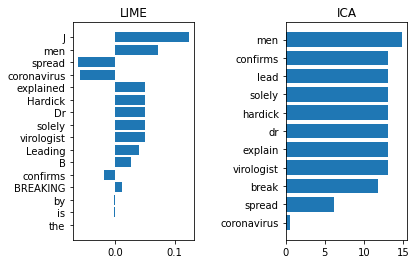

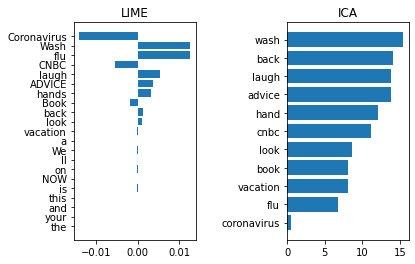

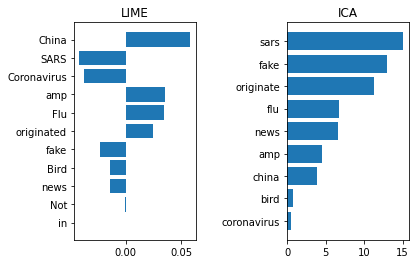

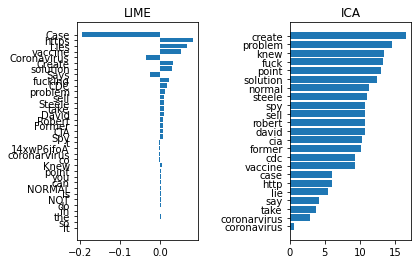

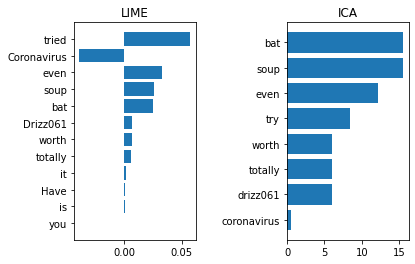

In [43]:
# unreliable tweets
unrel_indx = [123,169,245,266,278]

for i in unrel_indx:
    fname = 'tweet{}_plots'.format(i+1)
    
    tweet = tweets['Tweet'][i]
    num_words = len(re.split("\W+", tweet))
    exp = explainer.explain_instance(tweet, c.predict_proba, num_features = num_words)
    LIME_words = np.array(exp.as_list())[:,0]
    LIME_vals = np.array(exp.as_list())[:,1]
    LIME_vals = LIME_vals.astype(np.float)
    
    y_pos_LIME = np.arange(len(LIME_vals))
    
    df = termValDF.loc[get_tweet_words(tweets['Tweet'][i])]
    df.drop_duplicates(inplace = True) # drop duplicate occurrences of same word
    df = df.filter(regex = '^[a-zA-Z0-9]+$', axis = 0) # drop punctuation
    df.sort_values(by = 'net', ascending = False, inplace = True)
    ICA_vals = df['net'].tolist()
    ICA_words = df.index.values.tolist()
    
    y_pos_ICA = np.arange(len(ICA_vals))
    
    fig, axs = plt.subplots(1, 2)
    axs[0].barh(y_pos_LIME, LIME_vals)
    axs[0].set_yticks(y_pos_LIME)
    axs[0].set_yticklabels(LIME_words)
    axs[0].invert_yaxis()  # labels read top-to-bottom
    axs[0].set_title('LIME')
    axs[1].barh(y_pos_ICA, ICA_vals)
    axs[1].set_yticks(y_pos_ICA)
    axs[1].set_yticklabels(ICA_words)
    axs[1].invert_yaxis()  # labels read top-to-bottom
    axs[1].set_title('ICA')
    plt.subplots_adjust(wspace = 0.75)
    plt.savefig(fname, dpi = 300, bbox_inches = 'tight')

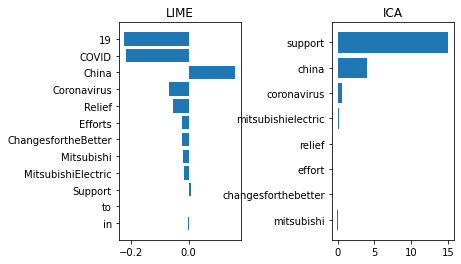

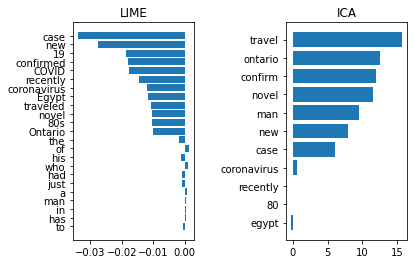

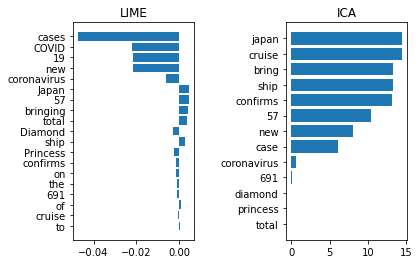

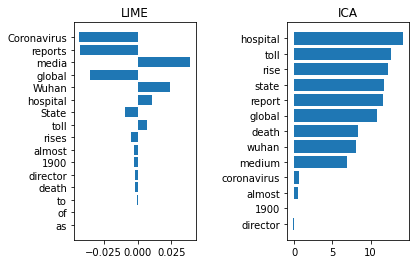

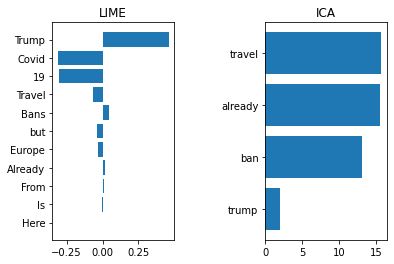

In [44]:
# reliable tweets
rel_indx = [389,402,410,472,517]

for i in rel_indx:
    fname = 'tweet{}_plots'.format(i+1)
    
    tweet = tweets['Tweet'][i]
    num_words = len(re.split("\W+", tweet))
    exp = explainer.explain_instance(tweet, c.predict_proba, num_features = num_words)
    LIME_words = np.array(exp.as_list())[:,0]
    LIME_vals = np.array(exp.as_list())[:,1]
    LIME_vals = LIME_vals.astype(np.float)
    
    y_pos_LIME = np.arange(len(LIME_vals))
    
    df = termValDF.loc[get_tweet_words(tweets['Tweet'][i])]
    df.drop_duplicates(inplace = True) # drop duplicate occurrences of same word
    df = df.filter(regex = '^[a-zA-Z0-9]+$', axis = 0) # drop punctuation
    df.sort_values(by = 'net', ascending = False, inplace = True)
    ICA_vals = df['net'].tolist()
    ICA_words = df.index.values.tolist()
    
    y_pos_ICA = np.arange(len(ICA_vals))
    
    fig, axs = plt.subplots(1, 2)
    axs[0].barh(y_pos_LIME, LIME_vals)
    axs[0].set_yticks(y_pos_LIME)
    axs[0].set_yticklabels(LIME_words)
    axs[0].invert_yaxis()  # labels read top-to-bottom
    axs[0].set_title('LIME')
    axs[1].barh(y_pos_ICA, ICA_vals)
    axs[1].set_yticks(y_pos_ICA)
    axs[1].set_yticklabels(ICA_words)
    axs[1].invert_yaxis()  # labels read top-to-bottom
    axs[1].set_title('ICA')
    plt.subplots_adjust(wspace = 0.75)
    plt.savefig(fname, dpi = 300, bbox_inches = 'tight')

In [45]:
len(unrel_tweets)

330

In [46]:
len(rel_tweets)

230